In [18]:
# Reproducibility setup
import os
import random
import numpy as np
import torch

SEED = 1234

# 1) Python, NumPy, PyTorch seeds
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# 2) CuDNN determinism settings (affects performance)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 3) Deterministic algorithms (PyTorch >= 1.8)
try:
    torch.use_deterministic_algorithms(True)
except Exception as e:
    print(f"Deterministic algorithms not fully available: {e}")

# 4) Optional: deterministic DataLoader shuffling
torch_gen = torch.Generator()
torch_gen.manual_seed(SEED)
print(f"Seeding complete with SEED={SEED}")

Seeding complete with SEED=1234


In [19]:
import pickle
N=5
n_epochs = 40
with open(f'processed_data_{N}.pkl', 'rb') as f:
    data = pickle.load(f)
    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']
    
X_mean = X_train.mean(axis=(0, 1), keepdims=True)
X_std  = X_train.std(axis=(0, 1), keepdims=True)

X_train = (X_train - X_mean) / X_std
X_test  = (X_test  - X_mean) / X_std

X_train.shape

# y_mean = y_train.mean()
# y_std  = y_train.std()

# y_train = (y_train - y_mean) / y_std
# y_test  = (y_test  - y_mean) / y_std

(568, 5, 10)

In [20]:
# Build and train multivariate RNN model using PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# Create DataLoader for batch training
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"\nData converted to tensors:")
print(f"X_train: {X_train_tensor.shape}")
print(f"y_train: {y_train_tensor.shape}")
print(f"Batch size: {batch_size}")

Using device: cpu

Data converted to tensors:
X_train: torch.Size([568, 5, 10])
y_train: torch.Size([568])
Batch size: 16


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# ---------- Hyperparams (tune as needed) ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16
num_epochs = 20               # same as your num_epochs_new
learning_rate = 1e-3
weight_decay = 1e-5
patience = 7                  # early stopping patience on val loss
clip_norm = 1.0

# Transformer architecture
a_d_model = 64                # embedding dimension
n_heads = 4
num_encoder_layers = 3
dim_feedforward = 128
dropout = 0.2

input_size = X_train_tensor.shape[-1]   # feature dimension (e.g., 10)
seq_len = X_train_tensor.shape[1]       # sequence length (e.g., 20)
output_size = 1                         # predicting one value

# ---------- Positional Encoding ----------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (B, L, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# ---------- Time Series Transformer ----------
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size: int, d_model: int, n_heads: int,
                 num_encoder_layers: int, dim_feedforward: int, dropout: float,
                 output_size: int = 1):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, output_size)
        )

    def forward(self, x):
        # x: (B, L, input_size)
        x = self.input_proj(x)           # (B, L, d_model)
        x = self.pos_enc(x)              # add positional encoding
        y = self.encoder(x)              # (B, L, d_model)
        last = y[:, -1, :]               # use last time step
        out = self.head(last)            # (B, output_size)
        return out.squeeze(-1)

# ---------- Instantiate model ----------
model = TimeSeriesTransformer(
    input_size=input_size,
    d_model=a_d_model,
    n_heads=n_heads,
    num_encoder_layers=num_encoder_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    output_size=output_size
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

print(model)

# ---------- Prepare data loaders with validation split ----------
# Use last 20% of train set as validation (time-series split)
val_size = int(0.2 * len(X_train_tensor))
if val_size < 1:
    raise ValueError("Training set too small for validation split. Reduce val fraction.")

X_val_tensor = X_train_tensor[-val_size:].to(device)
y_val_tensor = y_train_tensor[-val_size:].to(device)

X_train_sub = X_train_tensor[:-val_size]
y_train_sub = y_train_tensor[:-val_size]

train_dataset = TensorDataset(X_train_sub, y_train_sub)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# send test tensors to device (used only for logging at end)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# ---------- Training with early stopping (based on validation loss) ----------
best_val = float('inf')
patience_counter = 0
train_losses = []
val_losses = []
test_losses = []

log_file_path = f'training_log_improved_Transformer_{N}.txt'
with open(log_file_path, 'w') as logf:
    logf.write("Transformer Model Training Log\n")
    logf.write("="*60 + "\n")
    logf.write(f"d_model: {a_d_model}, heads: {n_heads}, layers: {num_encoder_layers}, ff: {dim_feedforward}, dropout: {dropout}\n")
    logf.write("="*60 + "\n\n")
    logf.write("Epoch, Train Loss, Val Loss, Test Loss\n")

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            preds = model(batch_X)            # shape (B,)
            loss = criterion(preds, batch_y)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            optimizer.step()

            epoch_loss += loss.item() * batch_X.size(0)

        avg_train_loss = epoch_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation (no grad)
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val_tensor)
            val_loss = criterion(val_preds, y_val_tensor).item()
            val_losses.append(val_loss)

            # Test loss for logging only
            test_preds = model(X_test_tensor)
            test_loss = criterion(test_preds, y_test_tensor).item()
            test_losses.append(test_loss)

        log_line = f"{epoch},{avg_train_loss:.6e},{val_loss:.6e},{test_loss:.6e}"
        logf.write(log_line + "\n")

        # Early stopping / checkpoint
        if val_loss < best_val - 1e-12:
            best_val = val_loss
            patience_counter = 0
            best_epoch = epoch
            torch.save(model.state_dict(), f'best_transformer_{N}.pth')
            best_note = " ← best"
        else:
            patience_counter += 1
            best_note = ""

        if epoch % 5 == 0 or patience_counter == 0:
            print(f"Epoch {epoch}/{num_epochs}  Train: {avg_train_loss:.6e}  Val: {val_loss:.6e}  Test: {test_loss:.6e}{best_note}")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch} (no improve for {patience} epochs). Best val: {best_val:.6e} at epoch {best_epoch}")
            break

# ---------- Load best model and final test evaluation ----------
model.load_state_dict(torch.load(f'best_transformer_{N}.pth', map_location=device))
model.eval()
with torch.no_grad():
    final_test_preds = model(X_test_tensor).cpu().numpy()
    final_test_loss = criterion(torch.from_numpy(final_test_preds), y_test_tensor.cpu()).item()

print("Best val loss:", best_val)
print("Final test loss (best model):", final_test_loss)

# Optionally: save losses / predictions for plotting
np.savez(f'transformer_training_results_N{N}.npz',
         train_losses=np.array(train_losses),
         val_losses=np.array(val_losses),
         test_losses=np.array(test_losses),
         final_test_preds=final_test_preds)


TimeSeriesTransformer(
  (input_proj): Linear(in_features=10, out_features=64, bias=True)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (head): Sequential(
    (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=64, out_features=

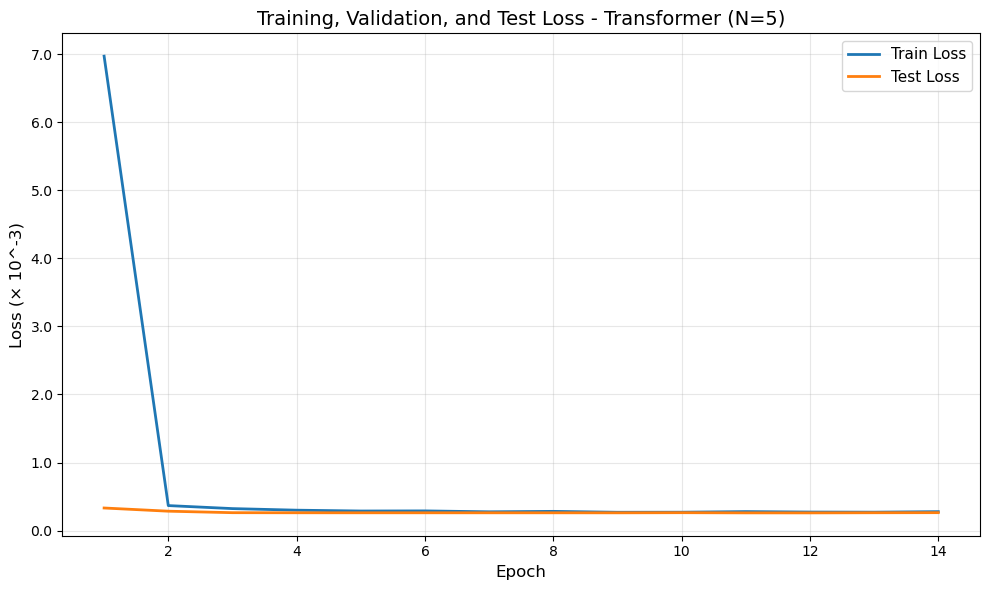

Showing epochs 1-50
Train Loss at epoch 14: 0.000279
Val Loss at epoch 14: 0.000279
Test Loss at epoch 14: 0.000264
Plot saved to: ./progress_report/media/training_loss_improved_Transformer_5.pdf


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Load training log for current N
log_path = f'training_log_improved_Transformer_{N}.txt'
with open(log_path, 'r') as f:
    lines = f.readlines()

# Parse the log file written as CSV lines: epoch,train,val,test
epochs = []
train_losses = []
val_losses = []
test_losses = []

for line in lines:
    line = line.strip()
    # Skip headers and separators
    if (not line) or line.startswith('=') or line.startswith('Transformer Model Training Log') or line.startswith('Epoch,'):
        continue
    # Accept lines that look like numeric CSV: e.g., 1,1.23e-03,1.11e-03,1.50e-03
    parts = line.split(',')
    if len(parts) == 4 and parts[0].strip().isdigit():
        try:
            epoch = int(parts[0].strip())
            train_loss = float(parts[1].strip())
            val_loss = float(parts[2].strip())
            test_loss = float(parts[3].strip())
            epochs.append(epoch)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            test_losses.append(test_loss)
        except ValueError:
            # Skip any malformed line
            continue

# Crop data to only show up to epoch 50
max_epoch = 50
epochs_cropped = [e for e in epochs if e <= max_epoch]
train_losses_cropped = train_losses[:len(epochs_cropped)]
val_losses_cropped = val_losses[:len(epochs_cropped)]
test_losses_cropped = test_losses[:len(epochs_cropped)]

# Create formatter for y-axis to show n × 10^-3
def formatter(x, pos):
    return f'{x * 1e3:.1f}'

# Plot training, validation and test loss (cropped to epoch 50)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(epochs_cropped, train_losses_cropped, label='Train Loss', linewidth=2)
# ax.plot(epochs_cropped, val_losses_cropped, label='Val Loss', linewidth=2)
ax.plot(epochs_cropped, test_losses_cropped, label='Test Loss', linewidth=2)

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss (× 10^-3)', fontsize=12)
ax.set_title(f'Training, Validation, and Test Loss - Transformer (N={N})', fontsize=14)
ax.yaxis.set_major_formatter(FuncFormatter(formatter))
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(f'./progress_report/media/training_loss_improved_Transformer_{N}.pdf')
plt.show()

print(f"Showing epochs 1-{max_epoch}")
if epochs_cropped:
    print(f"Train Loss at epoch {epochs_cropped[-1]}: {train_losses_cropped[-1]:.6f}")
    print(f"Val Loss at epoch {epochs_cropped[-1]}: {val_losses_cropped[-1]:.6f}")
    print(f"Test Loss at epoch {epochs_cropped[-1]}: {test_losses_cropped[-1]:.6f}")
print(f"Plot saved to: ./progress_report/media/training_loss_improved_Transformer_{N}.pdf")
